In [1]:
import seaborn as sns

import sklearn
from sklearn.cluster.bicluster import SpectralBiclustering
from sklearn.cluster.bicluster import SpectralCoclustering
from sklearn.metrics import consensus_score

import scipy.linalg
from functools import partial
%pylab
%matplotlib inline
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import scipy.sparse as sparse
from scipy import stats
from __future__ import print_function
import gc
from tqdm import tqdm_notebook as tqdm
from __future__ import division
import pandas as pd
import seaborn as sb
import os
from scipy.spatial import distance
from scipy.cluster import hierarchy
from pandas import DataFrame

import os, sys, datetime
LF_CODE_PATH = os.path.expanduser('~/projects/LFAnalyze/code')
FT_CODE_PATH = os.path.expanduser('~/projects/fishTrax/code/analysis/')
FD_CODE_PATH = os.path.expanduser('~/projects/fish_despair_notebooks/src/')
sys.path.insert(0,LF_CODE_PATH)
sys.path.insert(0,FT_CODE_PATH)
sys.path.insert(0,FD_CODE_PATH)

import passivity_2p_imaging_utils as p2putils
import visualization_utils as vizutil
reload(p2putils)
tmp_dir = '/tmp/'
all_data = p2putils.get_all_datasets(tmp_dir=tmp_dir)

f = all_data['e'][5]

import tensorflow as tf
# tf.enable_eager_execution()


# df, sig = f.get_cnmf_roi_table_and_signals()
M = f.get_signals_raw(z=None)

# data = np.load("../cnmf_f01555.npz")
# cnmf = data['cnmf'].astype(np.float32)
# raw = data['raw'].astype(np.float32)
# del data

def moving_average(a, n=3):
    # a is a signal
    ret = np.cumsum(a,0) # sum over time
    ret[n:] = ret[n:] - ret[:-n] # diff of n samples back
    rm = ret[n - 1:] / n
    pad_start = np.full((n-1,rm.shape[1]), rm[0])
    return np.vstack([pad_start, rm])

def ewma(data,span):
    "exponential weighted moving average."
    df = DataFrame(data)
    return df.ewm(span).mean().values

def df_f(x,ma_window=6,span=6):
    u = moving_average(x,ma_window)
    return ewma((x - u)/u, span)

# neurons = sig.T
neurons = M.T

neuron_ids = np.sort(np.argsort(neurons.std(0))[-5000:])
df = f.get_roi_table()
df = df.iloc[neuron_ids]
df.reset_index(drop=True, inplace=True)
neurons = neurons[:,neuron_ids]

/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
from scipy import signal

In [3]:
neurons = signal.decimate(neurons,4, axis=0)

/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/scipy/signal/signaltools.py:3445: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


In [4]:
neurons = df_f(neurons).astype(np.float32)
neurons = (neurons - neurons.mean(0))/(neurons.std(0)+1e-8)

In [5]:
def construct_pairwise_batches(X, lag=1, startIdx=None, endIdx=None, bias=True):
    """constructs batch x nT-lag x nBeta. i*ncol+j index is granger model of influence from i->j.
    
    Use startIdx and endIdx to choose a certain number of rows,
    eg startIdx=0, endIdx=5, X.shape[1]=100 would be a batch of 100^2=10,000.
    
    WARNING: if endIdx>N, will fill with 1s so batch stays same size."""
    
    nT, N = X.shape
    if endIdx:
        bz = (endIdx - startIdx) * N
    else:
        startIdx=0
        endIdx=N
        bz = N**2
#     print([bz, nT-lag, 2*lag+bias])
    granger = np.ones([bz, nT-lag, 2*lag+bias])
    null = np.ones([bz, nT-lag, lag+bias])
    newY = np.ones([bz, nT-lag, 1])
    Y = X[lag:]
    # time x neuron x lag
    l = 0
    X_lag = np.concatenate([X[l:-(lag-l)][:,:,None] for l in reversed(range(lag))], 2)
    biasTerm = np.ones([nT-lag,1])
    for i, n1 in enumerate(range(startIdx,min(N,endIdx))):
        for j, n2 in enumerate(range(N)):
            if bias:
#                 print([x.shape for x in [X_lag[:,n1], X_lag[:,n2], biasTerm]])
                grow = np.concatenate([X_lag[:,n1], X_lag[:,n2], biasTerm], 1)
                nrow = np.concatenate([X_lag[:,n2], biasTerm], 1)
            else:
                grow = np.concatenate([X_lag[:,n1], X_lag[:,n2]], 1)
                nrow = np.concatenate([X_lag[:,n2]], 1)
#             print(i,j)
            granger[i*N+j] = grow
            null[i*N+j] = nrow
            newY[i*N+j] = Y[:,[n2]]
    return newY, granger, null

In [93]:
with tf.Session() as sess:
    Y, x_granger, x_null = construct_pairwise_batches(neurons,1,0,1)
    granger = Granger(x_granger.shape, x_null.shape, Y.shape, sess=sess, l2=0.0)
    gbeta, g_residuals = granger.granger(x_granger, Y)
    nbeta, n_residuals = granger.null(x_null, Y)

In [94]:
gbeta

(5000, 3, 1)

In [138]:
def f_value(resA, resB, n_params_A, n_params_B, n):
    return ( (resA-resB)/(n_params_B-n_params_A) ) / (resB/(n-n_params_B))

class Granger():
    def __init__(self, x_granger_shape, x_null_shape, y_shape, sess, l2=0.0):
        self.x_granger = tf.placeholder(dtype=tf.float32, shape=x_granger_shape)
        self.x_null = tf.placeholder(dtype=tf.float32, shape=x_null_shape)
        self.y = tf.placeholder(dtype=tf.float32, shape=y_shape)
        self.n_params_granger = x_granger_shape[-1]
        self.n_params_null = x_null_shape[-1]
        self.l2 = l2
        self.sess = sess
        
    def granger(self, X, Y):
        gbeta = tf.matrix_solve_ls(self.x_granger, self.y, l2_regularizer=self.l2, fast=False)
        g_residuals = tf.reduce_sum(((tf.matmul(self.x_granger,gbeta) - self.y)**2)[:,:,0], 1)
        gbeta, g_residuals = self.sess.run([gbeta, g_residuals],
                                      feed_dict={self.x_granger: X, self.y: Y})
        return gbeta, g_residuals
    
    def null(self, X, Y):
        gbeta = tf.matrix_solve_ls(self.x_null, self.y, l2_regularizer=self.l2, fast=False)
        g_residuals = tf.reduce_sum(((tf.matmul(self.x_null,gbeta) - self.y)**2)[:,:,0], 1)
        gbeta, g_residuals = self.sess.run([gbeta, g_residuals],
                                      feed_dict={self.x_null: X, self.y: Y})
        return gbeta, g_residuals

def pairwise_granger_f_val(neurons, lag=1, bz=10):
    "all_gbeta is granger then autocorr then bias."
    nT, N = neurons.shape
    Y, x_granger, x_null = construct_pairwise_batches(neurons,lag,0,bz)
    fvals = np.zeros([N,N])
    all_gbeta = np.zeros([N,N,2*lag+1])
    all_nbeta = np.zeros([N,N,lag+1])
    with tf.Session() as sess:
        granger = Granger(x_granger.shape, x_null.shape, Y.shape, sess=sess, l2=0.0)
        for start in tqdm(range(0,N,bz)):
            end = start+bz
            Y, x_granger, x_null = construct_pairwise_batches(neurons,1,start,end)
            gbeta, g_residuals = granger.granger(x_granger, Y)
            nbeta, n_residuals = granger.null(x_null, Y)
            batch_fvals = f_value(g_residuals, n_residuals, granger.n_params_granger, granger.n_params_null, N)
            # account for N % batch != 0
            true_end = min(start+bz,N)
            batch_fvals = batch_fvals.reshape(-1,N)
            batch_gbeta = gbeta.reshape(-1,N,2*lag+1)
            batch_nbeta = nbeta.reshape(-1,N,lag+1)
            if start+bz>N:
                batch_true_end = N-start
                batch_fvals = batch_fvals[:batch_true_end]
                batch_gbeta = batch_gbeta[:batch_true_end]
                batch_nbeta = batch_nbeta[:batch_true_end]
            fvals[start:true_end] = batch_fvals
            all_gbeta[start:true_end] = batch_gbeta
            all_nbeta[start:true_end] = batch_nbeta
    return fvals, all_gbeta, all_nbeta

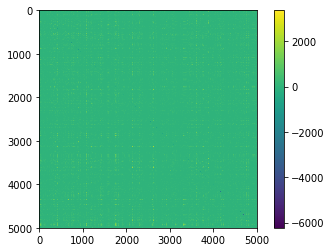

In [139]:
fvals, gbeta, nbeta = pairwise_granger_f_val(neurons, 1, 10)

plt.imshow(f_vals)
plt.colorbar()

In [140]:
gbeta.shape

(5000, 5000, 3)

In [144]:
kth

2000

In [141]:
idxMax = np.unravel_index(np.argmax(fvals),fvals.shape)
idxMin = np.unravel_index(np.argmin(fvals),fvals.shape)
idxSmall = np.unravel_index(np.argpartition(fvals.reshape(-1),kth)[kth-1], fvals.shape)

In [142]:
idxMax

(317, 3763)

In [143]:
idxSmall

(2362, 1524)

Text(0.5,1,'i->j (idxMax)')

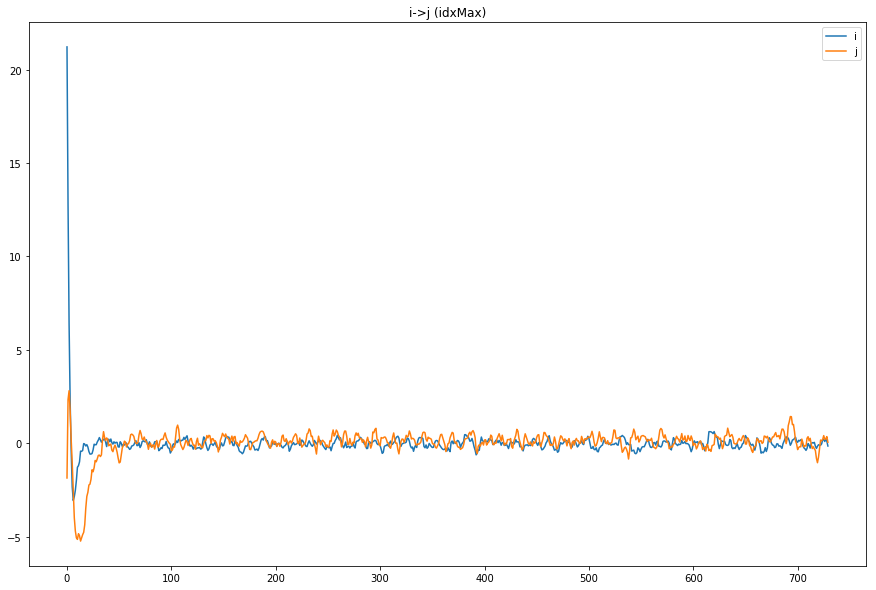

In [145]:
plt.figure(figsize=(15,10))
plt.plot(neurons[:-1,idxMax[0]])
plt.plot(neurons[1:,idxMax[1]])
plt.legend(["i","j"])
plt.title("i->j (idxMax)")

Text(0.5,1,'i->j (idxMax)')

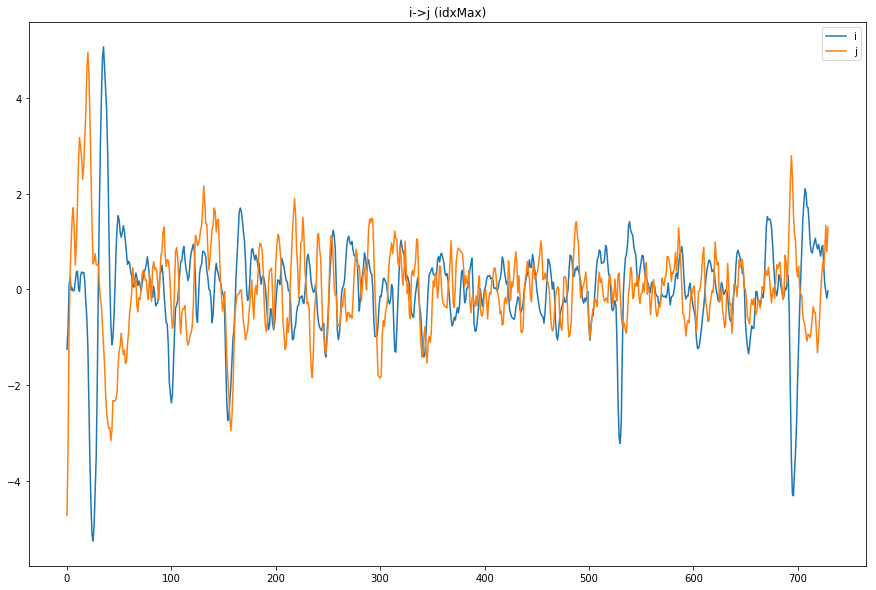

In [146]:
i = idxSmall
plt.figure(figsize=(15,10))
plt.plot(neurons[:-1,i[0]])
plt.plot(neurons[1:,i[1]])
plt.legend(["i","j"])
plt.title("i->j (idxMax)")

0.2447613 0.0804132


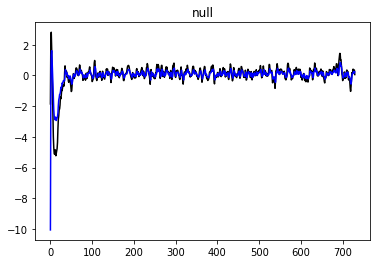

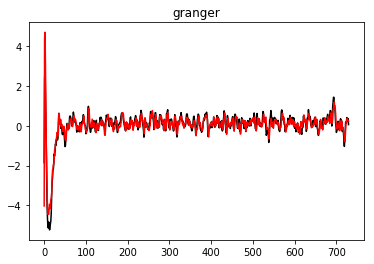

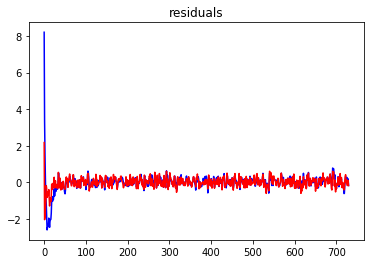

In [148]:
i = idxMax
y = neurons[1:,i[1]]
y_null = neurons[:-1,i[1]]*nbeta[i[0],i[1],0] + nbeta[i[0],i[1],1] 
y_grang = neurons[:-1,i[0]]*gbeta[i[0],i[1],0] + neurons[:-1,i[1]]*gbeta[i[0],i[1],1] + gbeta[i[0],i[1],2] 
plt.figure()
plot(y,'k')
plot(y_null,'b')
plt.title("null")

plt.figure()
plot(y,'k')
plot(y_grang,'r')
plt.title("granger")

plt.figure()
plot(y-y_null,'b')
plot(y-y_grang,'r')
plt.title("residuals")
print(np.mean(np.power(y-y_null,2)), np.mean(np.power(y-y_grang,2)))

0.14808485 0.14808483


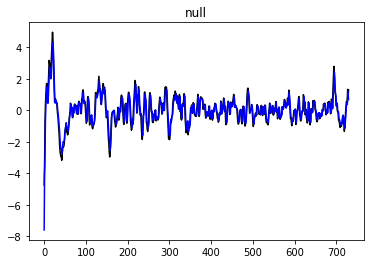

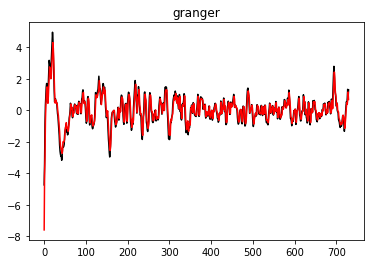

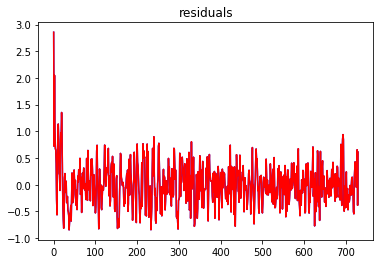

In [149]:
i = idxSmall
y = neurons[1:,i[1]]
y_null = neurons[:-1,i[1]]*nbeta[i[0],i[1],0] + nbeta[i[0],i[1],1] 
y_grang = neurons[:-1,i[0]]*gbeta[i[0],i[1],0] + neurons[:-1,i[1]]*gbeta[i[0],i[1],1] + gbeta[i[0],i[1],2] 
plt.figure()
plot(y,'k')
plot(y_null,'b')
plt.title("null")

plt.figure()
plot(y,'k')
plot(y_grang,'r')
plt.title("granger")

plt.figure()
plot(y-y_null,'b')
plot(y-y_grang,'r')
plt.title("residuals")
print(np.mean(np.power(y-y_null,2)), np.mean(np.power(y-y_grang,2)))

In [158]:
2

2

In [ ]:
2

In [159]:
np.savez("/data2/trained_models/{}_fvals_granger_4x_decimate.npy".format(f.fishid),f_vals=f_vals, gbeta=gbeta, nbeta=nbeta)

(4716, 103)
0.1299027 0.1299027


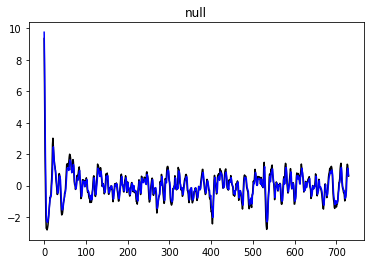

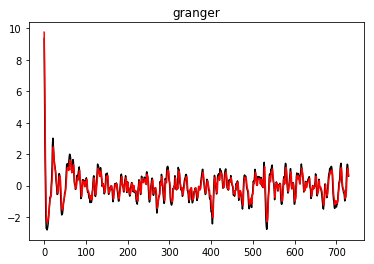

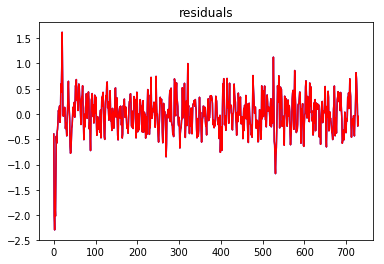

In [155]:
kth = 1805
i = np.unravel_index(np.argpartition(fvals.reshape(-1),kth)[kth-1], fvals.shape)
print(i)
y = neurons[1:,i[1]]
y_null = neurons[:-1,i[1]]*nbeta[i[0],i[1],0] + nbeta[i[0],i[1],1] 
y_grang = neurons[:-1,i[0]]*gbeta[i[0],i[1],0] + neurons[:-1,i[1]]*gbeta[i[0],i[1],1] + gbeta[i[0],i[1],2] 
plt.figure()
plot(y,'k')
plot(y_null,'b')
plt.title("null")

plt.figure()
plot(y,'k')
plot(y_grang,'r')
plt.title("granger")

plt.figure()
plot(y-y_null,'b')
plot(y-y_grang,'r')
plt.title("residuals")
print(np.mean(np.power(y-y_null,2)), np.mean(np.power(y-y_grang,2)))

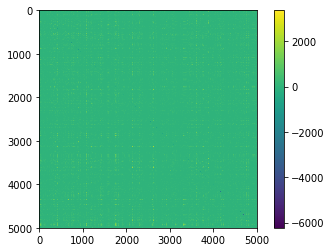

In [8]:
f_vals = pairwise_granger_f_val(neurons, 1, 10)

plt.imshow(f_vals)
plt.colorbar()

In [10]:
# f_vals = np.load("/data2/trained_models/181002_fvals.npy")
np.save("/data2/trained_models/{}_fvals_4x_decimate.npy".format(f.fishid),f_vals)

In [11]:
def cm_cycle(i):
    i = i - 1
    cmap = plt.get_cmap("tab10")
    color = cmap(i%10)
    if i%10==7:
        color = (color[0],color[1],color[2]+0.4)
    return color

In [12]:
row_corr = np.corrcoef(f_vals)

row_linkage = hierarchy.linkage(
    distance.pdist(row_corr), method='ward')

In [13]:
f_vals.T.shape

(5000, 5000)

In [14]:
col_corr = np.corrcoef(f_vals.T)
col_linkage = hierarchy.linkage(
    distance.pdist(col_corr.T), method='ward')

In [15]:
g_nclust = 10
row_clusters = hierarchy.fcluster(row_linkage,g_nclust,criterion='maxclust')
col_clusters = hierarchy.fcluster(col_linkage,g_nclust,criterion='maxclust')

In [16]:
vmax = max(np.abs(np.percentile(f_vals,0.1)), np.abs(np.percentile(f_vals,99.9)))

In [17]:
vmax

1026.1092540283225

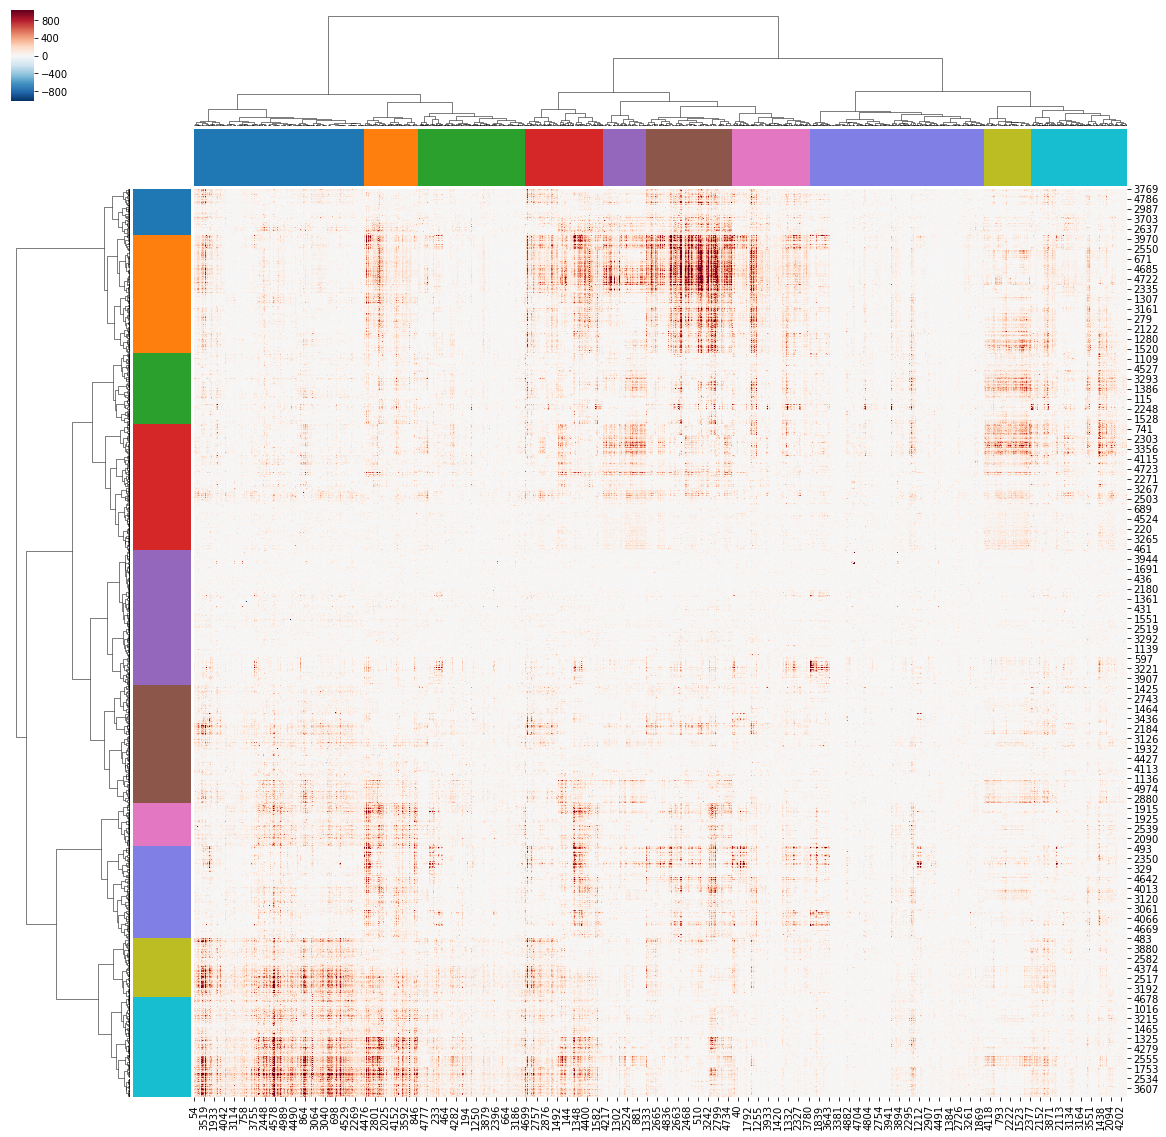

In [18]:
cm = sb.clustermap(f_vals, row_linkage=row_linkage, row_colors=[cm_cycle(c) for c in row_clusters],
        col_linkage=col_linkage, col_colors=[cm_cycle(c) for c in col_clusters],
        figsize=(20, 20),cmap="RdBu_r", vmin=-vmax,vmax=vmax)

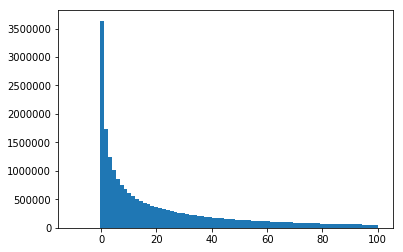

In [24]:
plt.hist(f_vals.reshape(-1), np.linspace(-10,100,80));

In [ ]:
np.quantile

In [61]:
neurons.shape

(731, 5000)

In [68]:
np.quantile(f_vals.reshape(-1),.17)

1.5647314381599426

In [60]:
np.percentile(f_vals.reshape(-1),20)

2.184750556945801

In [63]:
np.percentile(f_vals.reshape(-1),10)

0.5320702731609345

In [62]:
np.percentile(f_vals.reshape(-1),90)

132.15799407959014

In [25]:
# Z = [0,2,4,6,8,10]
Z = [0,2,4,6,]
# Z = [4]
nZ = len(Z)
back_img = []
for z in Z:
    back_img.append(np.power(f.get_tif_rasl_as_vol(z,range(1,200)).mean(axis=2),.4))
    

multi
multi
multi
multi
multi
multi
multi
multi
multi
multi
multi
multi
multi
multi
multi
multi
multi
multi
multi
multi
multi
multi
multi
multi
multi
multi
multi
multi
multi
multi
multi
multi
multi
multi
multi
multi
multi
multi
multi
multi


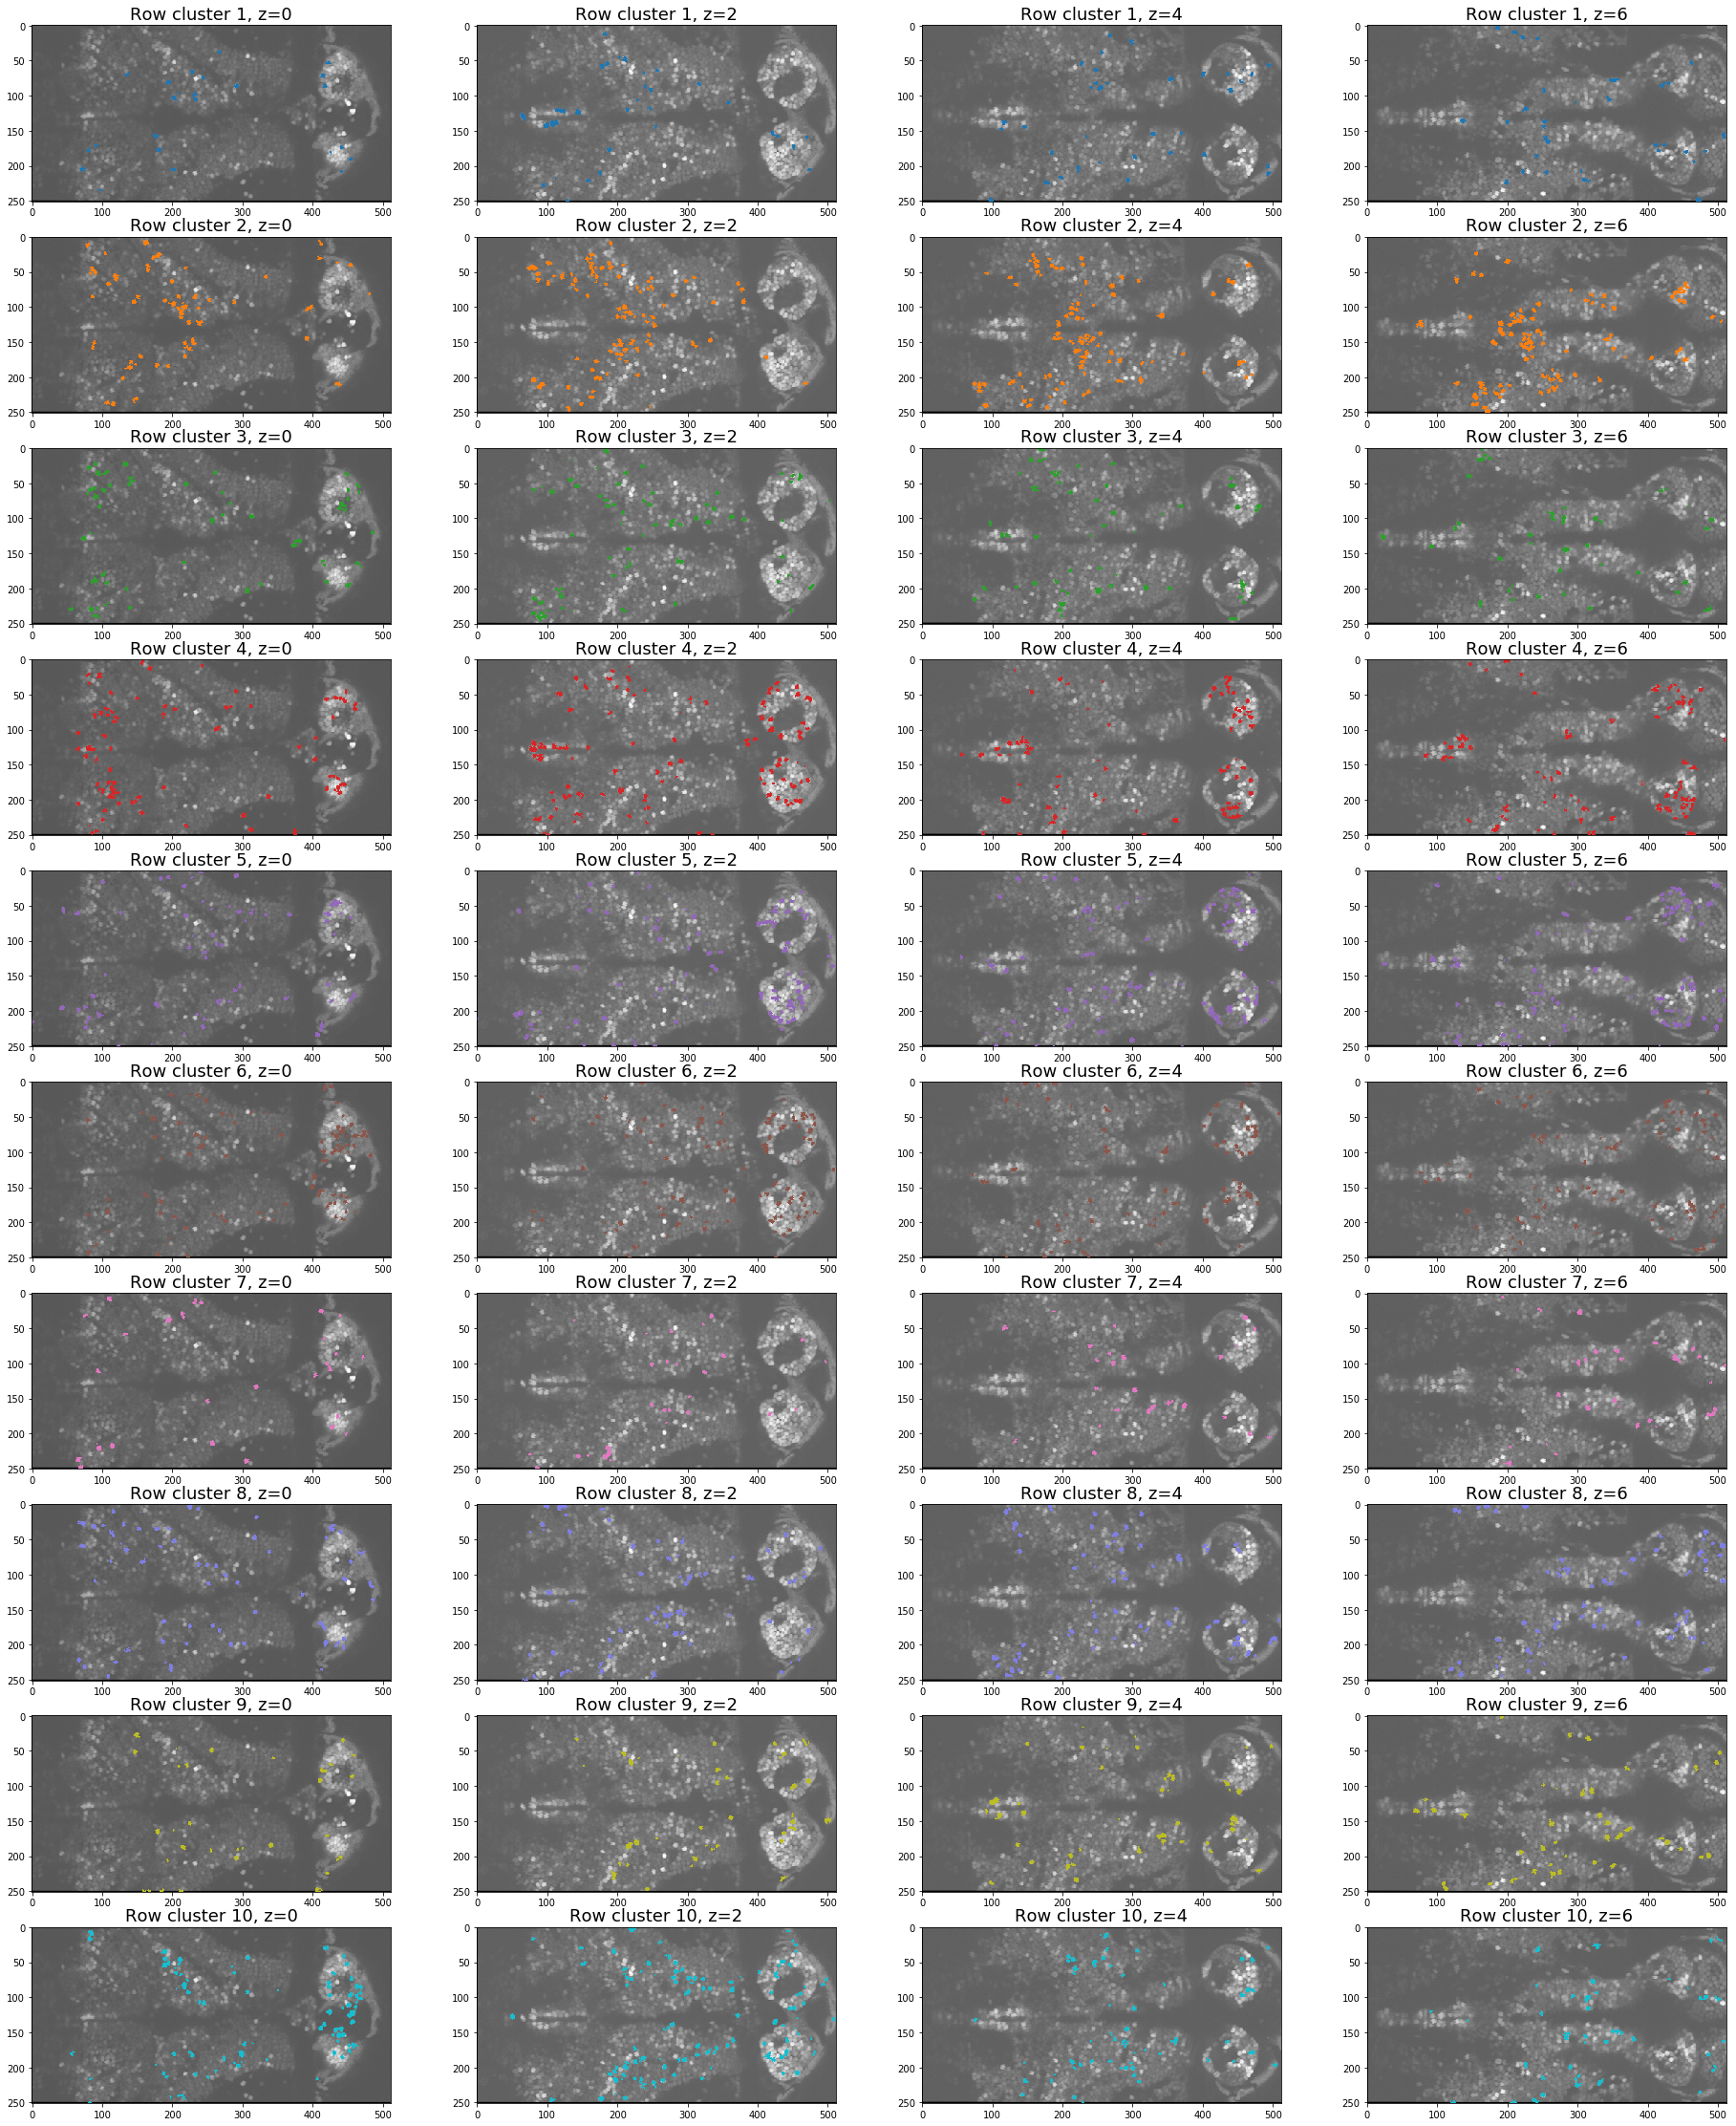

In [26]:
# nrows = len(row_clust_to_plot)
# nZ = 1
nrows = g_nclust
plt.subplots(nrows,nZ, figsize=[8*nZ,4*nrows])
for ic, clust in enumerate(range(1, g_nclust+1)):
# for ic,clust in enumerate(row_clust_to_plot):
    for iz, z in enumerate(Z):
        #Select rois in raphe in this slices, and get their coordinates.
#         coords = df[(row_clusters==clust)].coords
        coords = df[(row_clusters==clust) & (df.z==z)].coords
#         poly_coords = df[(row_clusters==clust) & (df.z==z)].poly
#         poly_coords = df[(row_clusters==clust)].poly
#         coords = [np.round(poly[~np.isnan(poly).any(axis=1)])[:,(1,0)].astype(int) for poly in poly_coords]
        plt.subplot(nrows,nZ,ic*nZ+iz+1)
        #Overlay the ROIs on the background image and display:
        # hack iz hardcode
        img = vizutil.overlay_coords(back_img[iz], coords, list(cm_cycle(clust)[:3]), alpha=1)
        plt.imshow(img,interpolation='nearest')
        plt.title("Row cluster {}, z={}".format(clust,z),fontsize=18)

multi
multi
multi
multi
multi
multi
multi
multi
multi
multi
multi
multi
multi
multi
multi
multi
multi
multi
multi
multi
multi
multi
multi
multi
multi
multi
multi
multi
multi
multi
multi
multi
multi
multi
multi
multi
multi
multi
multi
multi


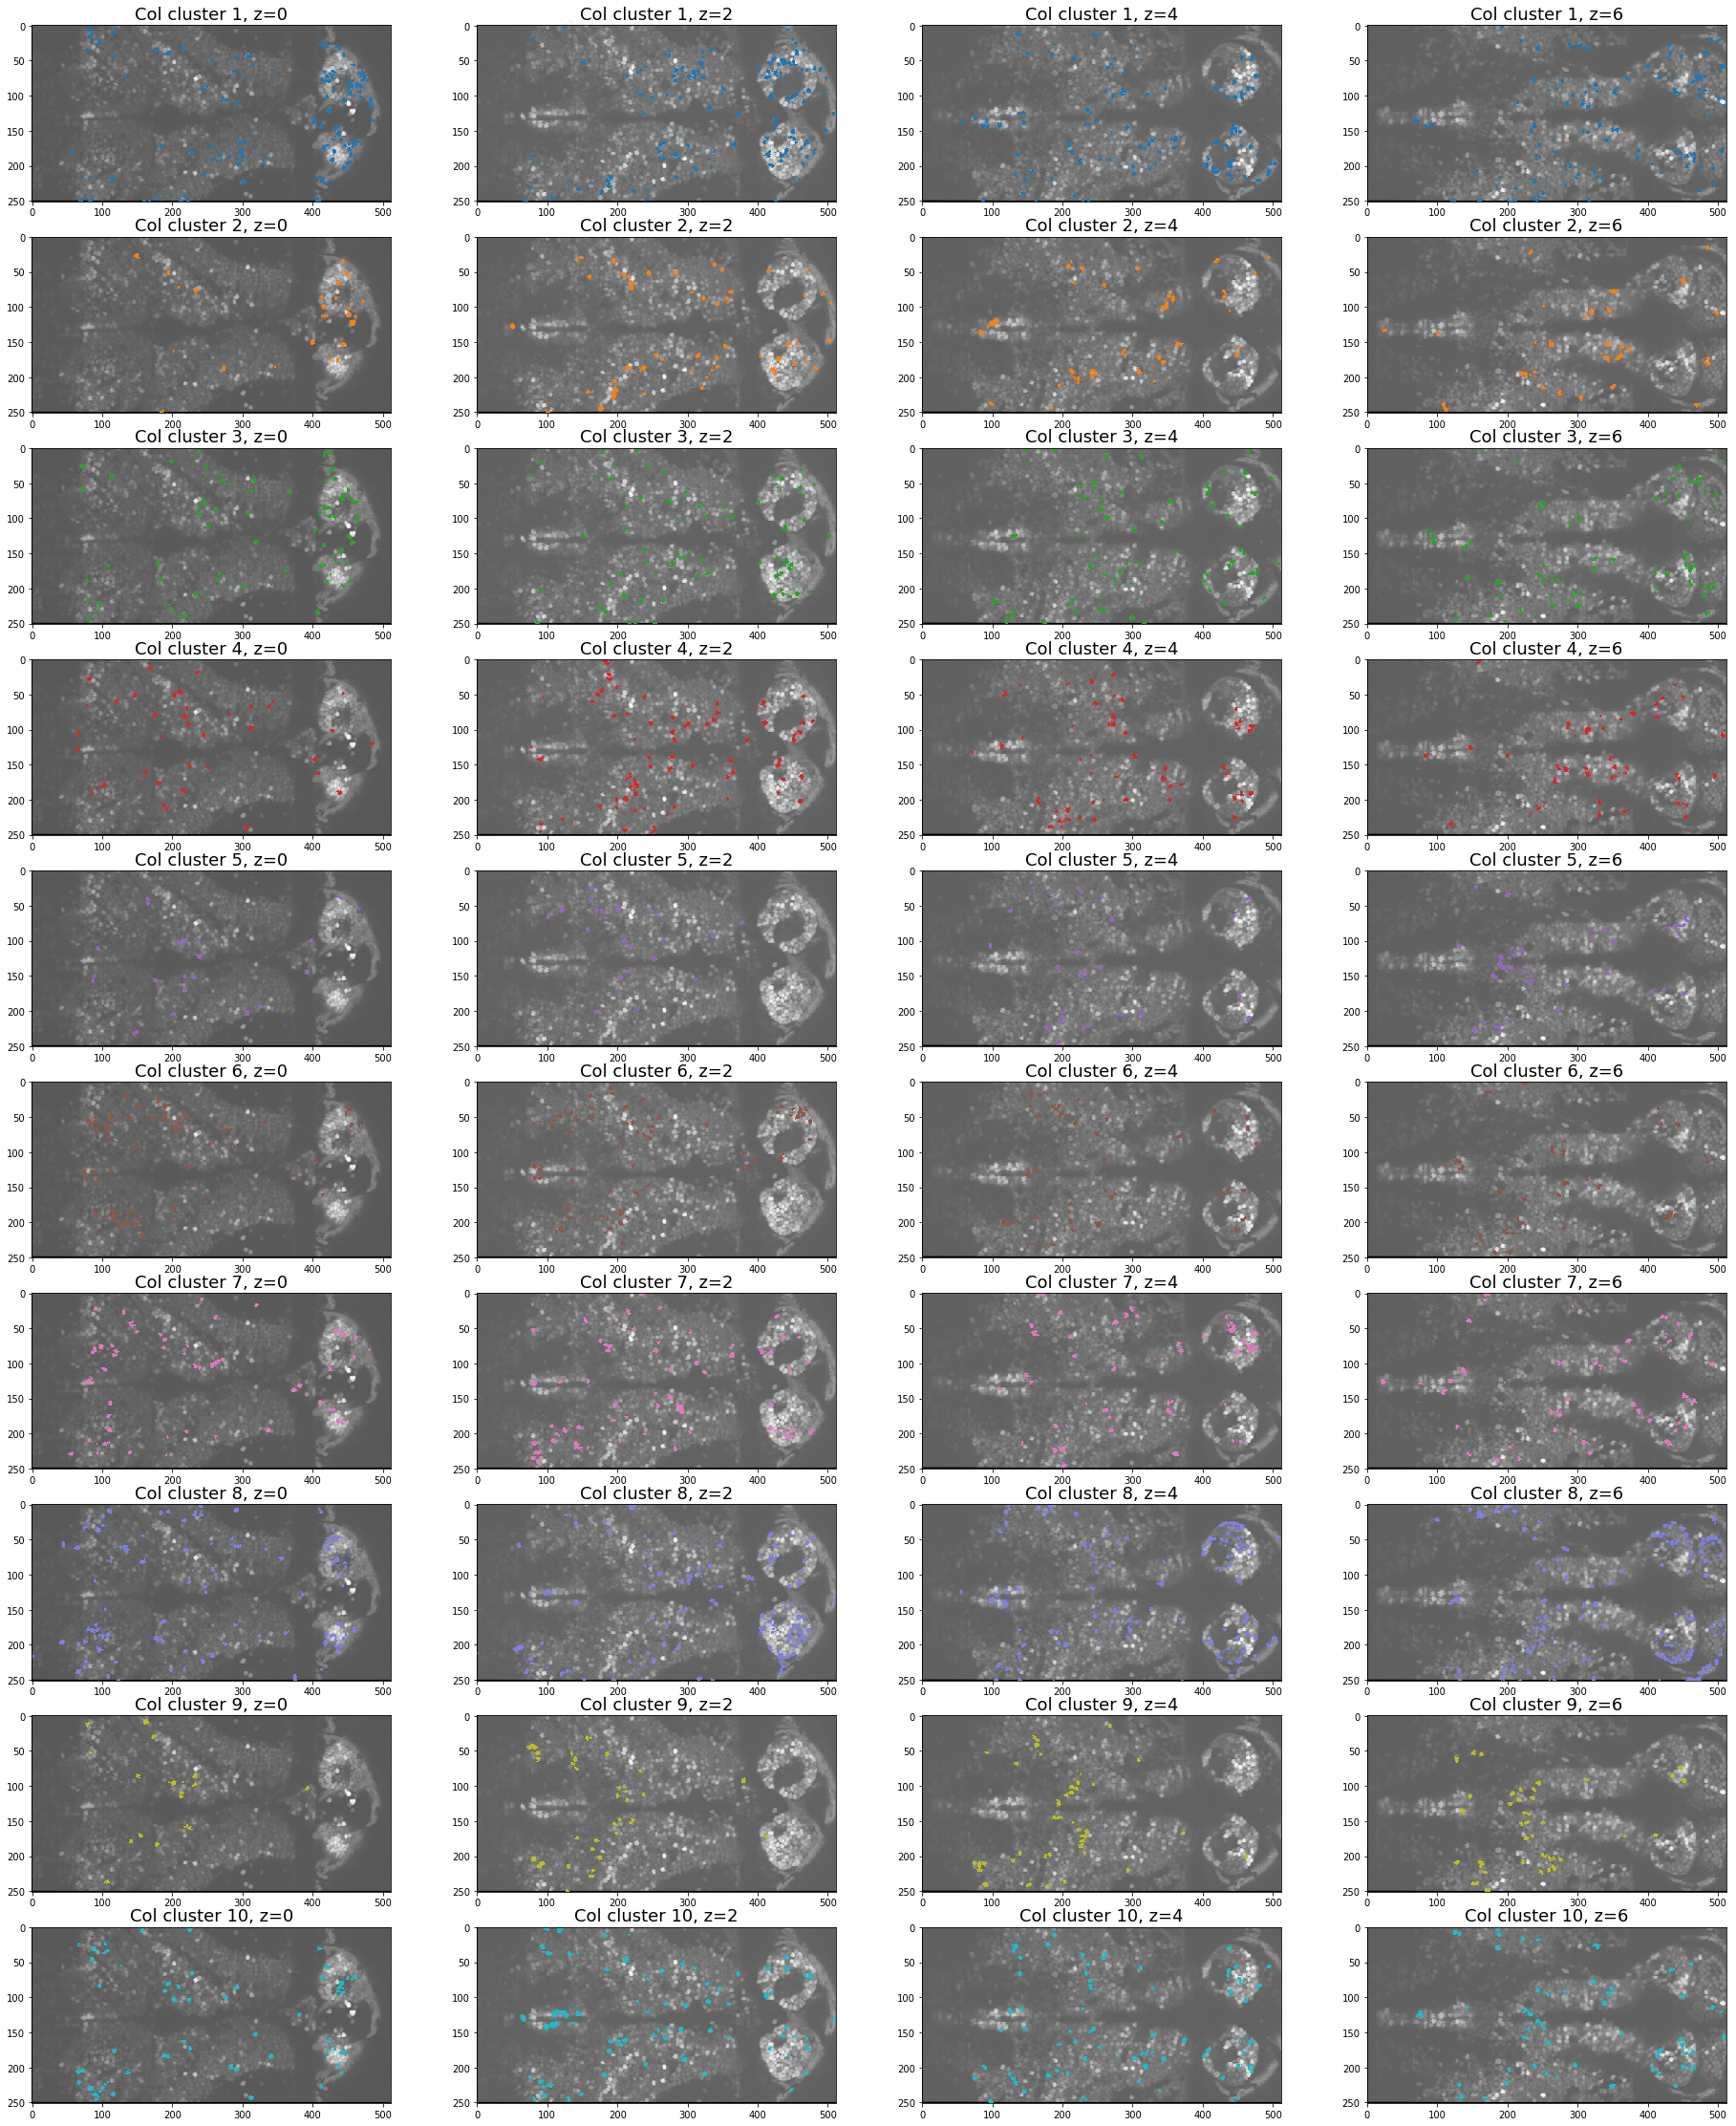

In [27]:
# nrows = len(col_clust_to_plot)
plt.subplots(nrows,nZ, figsize=[8*nZ,4*nrows])
for ic,clust in enumerate(range(1,g_nclust+1)):
# for ic,clust in enumerate(col_clust_to_plot):
    for iz, z in enumerate(Z):
        #Select rois in raphe in this slices, and get their coordinates.
        coords = df[(col_clusters==clust) & (df.z==z)].coords
#         poly_coords = df[(row_clusters==clust) & (df.z==z)].poly
#         coords = df[(col_clusters==clust)].coords
#         poly_coords = df[(col_clusters==clust)].poly
#         coords = [np.round(poly[~np.isnan(poly).any(axis=1)])[:,(1,0)].astype(int) for poly in poly_coords]
        plt.subplot(nrows,nZ,ic*nZ+iz+1)
        #Overlay the ROIs on the background image and display:
        img = vizutil.overlay_coords(back_img[iz], coords, list(cm_cycle(clust)[:3]), alpha=1)
        plt.imshow(img,interpolation='nearest')
        plt.title("Col cluster {}, z={}".format(clust,z),fontsize=18)

In [76]:
idxMax = np.unravel_index(np.argmax(f_vals),f_vals.shape)
idxMin = np.unravel_index(np.argmin(f_vals),f_vals.shape)

In [35]:
idxMax

(317, 3763)

In [50]:
kth = 2000
idxSmall = np.unravel_index(np.argpartition(f_vals.reshape(-1),kth)[kth-1], f_vals.shape)
idxSmall

(1105, 430)

In [72]:
neurons[:,idxMax]

array([[ 21.21412   , -17.833084  ],
       [ 12.794969  ,  -1.8546495 ],
       [  6.401449  ,   2.338134  ],
       ...,
       [  0.11150276,   0.25031352],
       [ -0.14374556,   0.35940433],
       [ -0.12526819,   0.0584273 ]], dtype=float32)

In [85]:
np.corrcoef(neurons[:-1,idxMax[0]], neurons[1:,idxMax[1]])

array([[1.        , 0.15344796],
       [0.15344796, 1.        ]])

Text(0.5,1,'i->j (idxMax)')

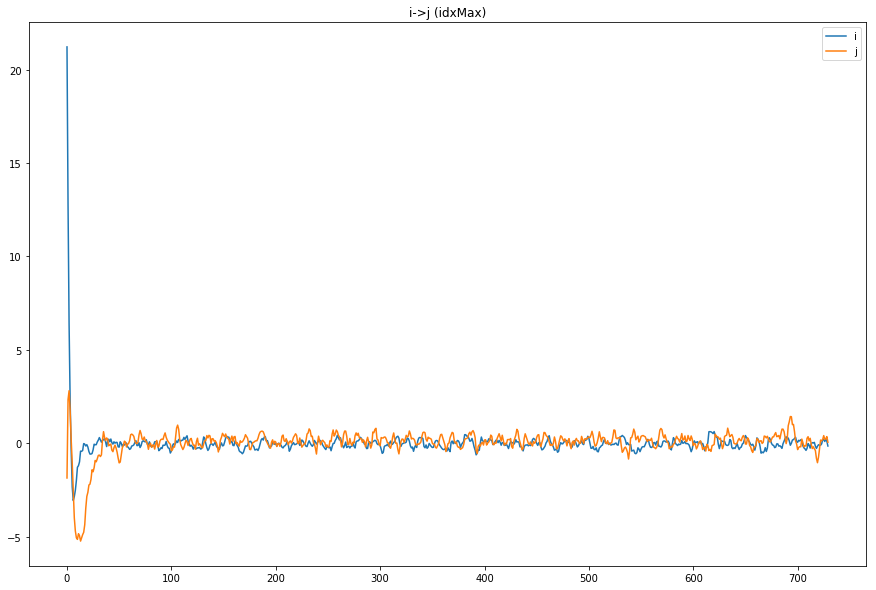

In [79]:
plt.figure(figsize=(15,10))
plt.plot(neurons[:-1,idxMax[0]])
plt.plot(neurons[1:,idxMax[1]])
plt.legend(["i","j"])
plt.title("i->j (idxMax)")

In [84]:
np.corrcoef(neurons[:-1,i[0]],neurons[1:,i[1]])

array([[1.        , 0.14830054],
       [0.14830054, 1.        ]])

Text(0.5,1,'i->j (idxMax)')

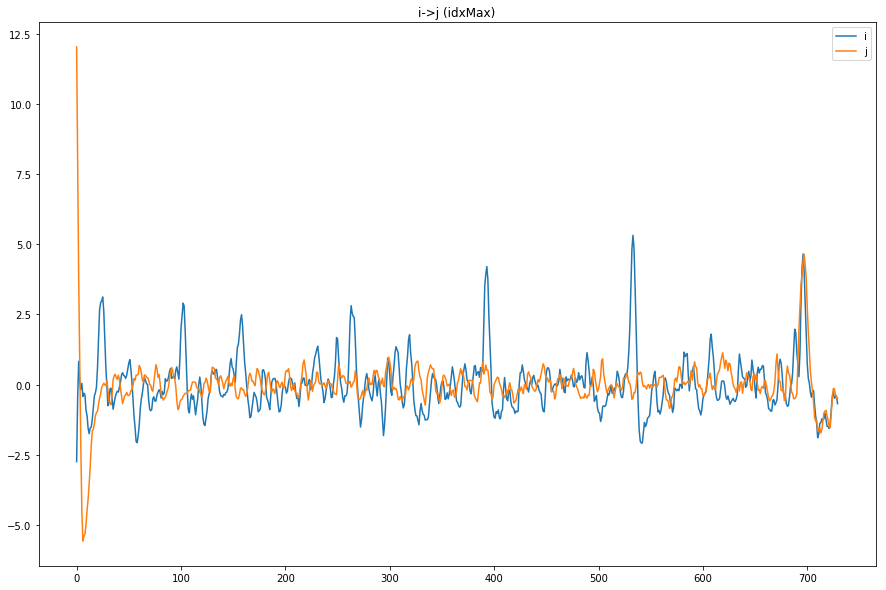

In [81]:
i = idxSmall
plt.figure(figsize=(15,10))
plt.plot(neurons[:-1,i[0]])
plt.plot(neurons[1:,i[1]])
plt.legend(["i","j"])
plt.title("i->j (idxMax)")

In [ ]:
plt.plot()

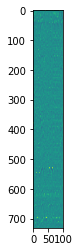

In [69]:
plt.imshow(neurons[:,0:100])

In [70]:
np.random.shuffle(neurons[:,0:100])

In [51]:
f_vals[idxSmall]

-0.0006848291959613562